<a href="https://colab.research.google.com/github/SoniaPMi/AI-3-RL/blob/main/A3C_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**texto en negrita**# A3C v1

In [ ]:
import gym
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import matplotlib.pyplot as plt
import random
from collections import deque
import datetime
from multiprocessing import cpu_count
import time
import threading
from typing import Optional


## Utils function:
Transform discrete states into one-hot vectors

In [ ]:
def discrete_input(state_discrete: tuple, env_dim: gym.spaces.tuple.Tuple):
    one_hot_state = []
    for i_pos, dim in zip(state_discrete, env_dim):
        temp = np.zeros(dim.n)
        temp[i_pos] = 1
        one_hot_state.append(temp)

    return np.concatenate(one_hot_state)

## A3C aproximator
This is the neural network for A3C

In [ ]:

class DenseNetA3C(Model):
    def get_config(self):
        pass

    def __init__(self, action_size, num_units=50, custom_env: bool = False):
        super(DenseNetA3C, self).__init__(name='a3c_dense')
        self.action_size = action_size
        self.dense1 = layers.Dense(num_units, activation='relu')
        self.policy = layers.Dense(action_size, activation='softmax')
        self.dense2 = layers.Dense(num_units, activation='relu')
        self.values = layers.Dense(1)
        self.custom_env = custom_env

    def call(self, inputs, training=None, mask=None):
        # Reshape input to allow input sequences into the fully connected network
        if self.custom_env:
            inputs = tf.reshape(inputs, [-1, inputs.shape[1] * inputs.shape[2]])

        # Forward pass
        x = self.dense1(inputs)
        policy_prob = self.policy(x)
        v1 = self.dense2(inputs)
        values = self.values(v1)
        return policy_prob, values

## A3C AGENT
This sections define the classes for the agent to operate with threading.
Each agent learns from its own experiences and then updates/synchronizes the learning with the global network.

In [ ]:

class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def store(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []


class A3CAgent(threading.Thread):
    # Set up global variables across different threads
    stop_signal = False
    global_episode = 0
    global_ema_reward = None
    best_score = None
    lock = threading.Lock()

    def __init__(self, env, local_model, opt, idx,
                 max_episodes=1000, update_freq=20, gamma=.99,
                 grad_prop: bool = False, normalize: bool = True,
                 c_actor: float = 1, c_critic: float = 0.5, c_entropy: float = 0.01,
                 ema_ratio: float = 0.01, early_stopping=None, max_steps_per_episode=200):
        super(A3CAgent, self).__init__()
        self.env = env
        self.local_model = local_model
        self.global_model = None
        self.opt = opt
        self.worker_idx = idx
        self.max_episodes = max_episodes
        self.update_freq = update_freq
        self.gamma = gamma
        self.name = ''
        self.folder_model = None
        self.summary_writer = None
        self.memory = Memory()
        self.eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0
        self.grad_prop: bool = grad_prop
        self.normalize: bool = normalize
        self.c_actor: float = c_actor
        self.c_critic: float = c_critic
        self.c_entropy: float = c_entropy
        self.ema_ratio: float = ema_ratio
        self.max_steps_per_episode: int = max_steps_per_episode
        self.early_stopping: Optional[float] = early_stopping

    def __record_results(self, episode_reward, worker_idx, episode_loss_mean, num_steps):
        """Helper function to store score and print statistics.

        Arguments:
          episode_reward: Reward accumulated over the current episode
          worker_idx: Which thread (worker)
          episode_loss_mean: The total loss accumulated over the current episode
          num_steps: The number of steps the episode took to complete
        """

        # Save Tensorboard
        with self.summary_writer.as_default():
            tf.summary.scalar('Episode Reward', episode_reward, step=A3CAgent.global_episode)
            tf.summary.scalar('Agent ID', self.worker_idx, step=A3CAgent.global_episode)
            tf.summary.scalar('Episode EMA Reward', A3CAgent.global_ema_reward, step=A3CAgent.global_episode)
            tf.summary.scalar('Episode Loss', episode_loss_mean, step=A3CAgent.global_episode)

        # Print in command line
        print(f"Episode: ({A3CAgent.global_episode + 1}/{self.max_episodes}) | "
              f"EMA Reward: {A3CAgent.global_ema_reward:.3} | "
              f"Reward: {episode_reward:.3} | "
              f"Loss: {episode_loss_mean:.3} | "
              f"Steps: {num_steps} | Worker: {worker_idx}")

    def __predict_action(self, current_state):
        probs, _ = self.local_model(tf.convert_to_tensor(current_state[None, :], dtype=tf.float32))
        action = np.random.choice(self.env.action_size, p=probs.numpy()[0])
        return action

    @staticmethod
    def __update_ema_reward(episode_reward, ema_ratio=0.01):
        if A3CAgent.global_ema_reward is None:
            A3CAgent.global_ema_reward = episode_reward
        else:
            A3CAgent.global_ema_reward = A3CAgent.global_ema_reward * (1 - ema_ratio) + episode_reward * ema_ratio

    def __compute_loss(self, done, new_state):
        if done:
            reward_sum = 0.  # terminal
        else:
            _, values_pred = self.local_model(tf.convert_to_tensor(new_state[None, :], dtype=tf.float32))
            reward_sum = values_pred.numpy()[0].item()

        # Estimate discounted reward for every step (matrix computation)
        rewards = self.memory.rewards + [reward_sum]
        gamma_n = np.power(self.gamma, np.arange(len(rewards)))
        returns = (rewards * gamma_n)[::-1].cumsum()[::-1] / gamma_n
        returns = returns[:-1]

        # Predict policy probabilities and values for given states
        states = np.stack(self.memory.states)
        policy_probs, values = self.local_model(tf.convert_to_tensor(states, dtype=tf.float32))

        # Normalize rewards to obtain more stability
        if self.normalize:
            returns = np.array(returns)
            returns = (returns - np.mean(returns)) / (np.std(returns) + self.eps)
            # returns = returns.tolist()

        # Estimate advantages
        advantage = tf.convert_to_tensor(returns[:, None], dtype=tf.float32) - values

        # Value loss
        value_loss = tf.square(advantage)

        # Policy loss
        actions = tf.one_hot(self.memory.actions, depth=self.env.action_size)
        pi = tf.reduce_sum(policy_probs * actions, axis=1, keepdims=True)  # select probs for given actions
        if self.grad_prop:
            policy_loss = - tf.math.log(pi + self.eps) * tf.stop_gradient(advantage)
        else:
            policy_loss = - tf.math.log(pi + self.eps) * advantage

        # Entropy to regularize loss
        entropy_policy = tf.reduce_sum(policy_probs * tf.math.log(policy_probs + self.eps), axis=1, keepdims=True)

        # Total loss
        total_loss = tf.reduce_mean(self.c_actor * policy_loss +
                                    self.c_critic * value_loss +
                                    self.c_entropy * entropy_policy)
        return total_loss

    def __train(self, done, new_state):
        # Calculate gradient wrt to local model. We do so by tracking the
        # variables involved in computing the loss by using tf.GradientTape
        with tf.GradientTape() as tape:
            total_loss = self.__compute_loss(done, new_state)

        # Calculate local gradients
        grads = tape.gradient(total_loss, self.local_model.trainable_weights)

        # Push local gradients to global model
        self.opt.apply_gradients(zip(grads, self.global_model.trainable_weights))

        # Update local model with new weights
        self.local_model.set_weights(self.global_model.get_weights())
        return total_loss.numpy()

    def __save_model(self):
        print(f'Saving best model to {self.folder_model}, episode score: {A3CAgent.best_score}')
        if not os.path.exists(self.folder_model):
            os.makedirs(self.folder_model)
        self.global_model.save_weights(os.path.join(self.folder_model, f'{self.name}.h5'))

    def __run_episodes(self):
        while A3CAgent.global_episode < self.max_episodes and not self.early_stop():
            current_state = self.env.reset()
            self.memory.clear()
            ep_reward = 0.
            ep_steps = 0
            ep_losses = 0

            time_count = 0
            done = False
            while not done or ep_steps > self.max_steps_per_episode:
                action = self.__predict_action(current_state)
                new_state, reward, done, _ = self.env.step(action)
                # if isinstance(self.env.observation_space, gym.spaces.tuple.Tuple):
                #     new_state = discrete_input(new_state, self.env.observation_space)
                ep_reward += reward
                self.memory.store(current_state, action, reward)

                if time_count == self.update_freq or done:
                    total_loss = self.__train(done, new_state)
                    self.memory.clear()
                    ep_losses += total_loss
                    time_count = 0

                    if done or ep_steps > self.max_steps_per_episode:
                        with A3CAgent.lock:
                            # Stop all the threads if max_episodes reached
                            if A3CAgent.global_episode >= self.max_episodes:
                                A3CAgent.stop_signal = True
                                break

                            # Average episode loss
                            episode_loss_mean = ep_losses / ep_steps

                            # Instantiate best_score with the first ep_reward.
                            if A3CAgent.best_score is None:
                                A3CAgent.best_score = ep_reward
                            #  Re-estimate moving average of the episode reward: A3CAgent.global_ema_reward
                            self.__update_ema_reward(ep_reward, ema_ratio=self.ema_ratio)

                            # Print Info and write Tensorboard
                            self.__record_results(ep_reward, self.worker_idx, episode_loss_mean, ep_steps)

                            # Save model only if it is better than the already stored.
                            if ep_reward > A3CAgent.best_score:
                                A3CAgent.best_score = ep_reward
                                self.__save_model()

                            if ep_steps > 100 and self.early_stop():
                                print("Solved at episode {}!".format(A3CAgent.global_episode))
                                A3CAgent.stop_signal = True
                                break

                            A3CAgent.global_episode += 1

                ep_steps += 1
                time_count += 1
                current_state = new_state

    def run(self):
        self.__run_episodes()
        A3CAgent.stop_signal = True

    # def stop(self):
    #     while True:
    #         if A3CAgent.stop_signal is True:
    #             break

    def early_stop(self):
        if self.early_stopping is not None and \
                A3CAgent.global_ema_reward is not None and \
                A3CAgent.global_ema_reward > self.early_stopping:
            return True
        else:
            return False


## A3C Runner
This is the section where the agents are coordinated

In [ ]:

class A3CRunner:
    def __init__(self, agent, global_model, name, folder_model, summary_writer):
        self.agent = agent
        self.global_model = global_model

        # # Build directories
        # run_date = time.strftime("%Y%m%d_%H%M%S")
        # folder_model = os.path.join('./models_a3c', name, run_date)
        # self.folder_tensor_board = os.path.join('./logs_tensorboard_a3c', name, run_date)

        # if not os.path.exists(self.folder_tensor_board):
        #     os.makedirs(self.folder_tensor_board)

        # # Tensorboard summary writer
        # summary_writer = tf.summary.create_file_writer(self.folder_tensor_board)

        # Transfer info to every worker
        for worker in self.agent:
            worker.global_model = self.global_model
            worker.summary_writer = summary_writer
            worker.folder_model = folder_model
            worker.name = name

        # Initialize global model to get weights later
        rand_state = self.agent[0].env.reset()[None, :]
        self.global_model(tf.convert_to_tensor(rand_state, dtype=tf.float32))

    def run(self):
        if A3CAgent.global_ema_reward is None:
            [worker.start() for worker in self.agent]
        else:
            A3CAgent.stop_signal = False
            A3CAgent.global_ema_reward = None
            [worker.run() for worker in self.agent]

        while True:
            if self.agent[0].stop_signal is True:
                break

        [w.join() for w in self.agent]

    def play(self, plays=100, max_steps_per_episode=100, show_plots=False):
        env = self.agent[0].env

        episode_rewards, episode_steps, entropy = [], [], []
        for plays_i in range(plays):
            current_state = env.reset()
            ep_reward = 0.
            ep_steps = 0
            done = False
            while not done or ep_steps > max_steps_per_episode:
                # action = self.agent[0].__predict_action(current_state)
                probs, _ = self.global_model(tf.convert_to_tensor(current_state[None, :], dtype=tf.float32))
                action = np.random.choice(env.action_size, p=probs.numpy()[0])

                entropy_i = probs.numpy()
                entropy.append(np.sum(-entropy_i * np.log(entropy_i)))

                new_state, reward, done, _ = env.step(action)

                ep_reward += reward
                ep_steps += 1
                current_state = new_state
            episode_rewards.append(ep_reward)
            episode_steps.append(ep_steps)

        print(f"Avg rewards: {np.mean(episode_rewards).round(2)} +/- {np.std(episode_rewards).round(2)}")
        print(f"Avg steps: {np.mean(episode_steps).round(2)} +/- {np.std(episode_steps).round(2)}")
        print(f"Avg entropy: {np.mean(entropy).round(2)} +/- {np.std(entropy).round(2)}")

        if show_plots:
            num_bins = 50
            x = np.array(episode_rewards)
            fig, ax = plt.subplots()

            # the histogram of the data
            n, bins, patches = ax.hist(x, num_bins, density=1)

            ax.set_xlabel('Episode rewards')
            ax.set_ylabel('Probability density')
            ax.set_title(f'Mean {np.mean(x).round(2)} +/- {np.std(x).round(2)}')

            # Tweak spacing to prevent clipping of ylabel
            fig.tight_layout()
            plt.show()


Disable GPU computation for local devices


In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Gym selection and basic configurations

In [ ]:
gym_name_list = [
    {
        'name': 'CartPole-v0',
        'goal': 180,
        'v_min': 0,
        'v_max': 210,
        'ep': 50
    },
    {
        'name': 'MountainCar-v0',
        'goal': -150, 
        'v_min': -210,
        'v_max': 0,
        'ep': 20
    },
    {
        'name': 'Blackjack-v0',
        'goal': 0.10,
        'v_min': -20,
        'v_max': 20,
        'ep': 1000
    }
]

env_i = 2 #@param {type:"slider", min:0, max:2, step:1}

save_model: bool = False # @param {type:"boolean"}
show_plots: bool = True # @param {type:"boolean"}

# The code fails when environment is rendered in COLAB.
render_env: bool = False # @param {type:"boolean"}
seed = 42 # @param {type:"integer"}

max_steps_per_episode = 200 # @param {type:"integer"}

print(f"These are the CPU cores available: {cpu_count()}")
N_WORKERS: int = 2 # @param {type:"integer"}

stopping_reward_criteria = gym_name_list[env_i]['goal']

gym_name = gym_name_list[env_i]['name']

envs = []
for _ in range(N_WORKERS):
    env = gym.make(gym_name)  # Create the environment
    if isinstance(env.observation_space, gym.spaces.tuple.Tuple):
        env = gym.wrappers.TransformObservation(env, lambda obs: discrete_input(obs, env.observation_space))
    env.seed(seed)
    env.action_size = env.action_space.n
    envs.append(env)

if isinstance(envs[0].observation_space, gym.spaces.tuple.Tuple):
    num_inputs = sum([x.n for x in envs[0].observation_space])
else:
    num_inputs = envs[0].observation_space.shape[0]
num_actions = envs[0].action_size

These are the CPU cores available: 2


In [ ]:
envs[0].observation_space


Tuple(Discrete(32), Discrete(11), Discrete(2))

## Algorithm hyper-parameters

In [ ]:
# Factor of the ema that displays that tracks the averaged rewards
ema_ratio = 0.01  # @param {type:"number"}

# Maximum steps in a episode
max_steps_per_episode: int = 200 # @param  {type:"integer"}

# Discount factor for estimating the futures rewards
gamma: float = 0.99  # @param {type:"number"}

# Decide if normalize the episode returns
normalize: bool = True  # @param {type:"boolean"}

# Decide if apply gradient propagation through critic value, in theory NOT.
grad_prop: bool = False  # @param {type:"boolean"}

# Weights in applied loss components
c_actor = 1.0  # @param {type:"number"}
c_critic = 0.5  # @param {type:"number"}
c_entropy = 0.01  # @param {type:"number"}

# The usual factor that controls the amount of change the weights are updated
learning_rate = 0.001 # @param {type:"number"}

# Factor to define heuristically the size of the hidden layer.
hidden_size_factor = 16 # @param {type:"integer"}
num_hidden = num_inputs * num_actions * hidden_size_factor

## Tensorboard configuration

In [ ]:
implementation = "A3C_v0"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = os.path.join("logs", gym_name, implementation, "T_" + current_time)
summary_writer = tf.summary.create_file_writer(train_log_dir)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# %reload_ext tensorboard

# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

# # Control TensorBoard display. If no port is provided, 
# # the most recently launched TensorBoard is used
# notebook.display(port=6006, height=1000) 

%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 144), started 0:16:11 ago. (Use '!kill 144' to kill it.)

<IPython.core.display.Javascript object>

## Main function (script) to activate the learning:
The logic is in the A3C agent and runner. This just instantiate the classes.

In [ ]:

# OPT = tf.keras.optimizers.Adam(learning_rate=learning_rate, use_locking=True)
OPT = tf.compat.v1.train.AdamOptimizer(learning_rate, use_locking=True)

# Neural approximator
neural_nets = [DenseNetA3C(action_size=envs[0].action_size,
                           num_units=num_hidden,
                           custom_env=False) for _ in range(N_WORKERS + 1)]


# Agent
workers = [A3CAgent(env=envs[i],
                    local_model=neural_nets[i],
                    opt=OPT,
                    idx=i,
                    max_episodes=15000,
                    update_freq=20,
                    gamma=gamma,
                    grad_prop=grad_prop,
                    c_actor=c_actor,
                    c_critic=c_critic,
                    c_entropy=c_entropy,
                    ema_ratio=ema_ratio,
                    early_stopping=stopping_reward_criteria,
                    max_steps_per_episode=max_steps_per_episode) for i in range(N_WORKERS)]

# Runner
runner = A3CRunner(agent=workers,
                   global_model=neural_nets[-1],
                   name=implementation,
                   folder_model=train_log_dir,
                   summary_writer=summary_writer)

runner.run()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:191: RuntimeWarning: divide by zero encountered in double_scalars


Episode: (1/15000) | EMA Reward: -1.0 | Reward: -1.0 | Loss: inf | Steps: 0 | Worker: 1
Episode: (2/15000) | EMA Reward: -0.98 | Reward: 1.0 | Loss: -inf | Steps: 0 | Worker: 0
Saving best model to logs/Blackjack-v0/A3C_v0/T_20220309-003000, episode score: 1.0
Episode: (3/15000) | EMA Reward: -0.96 | Reward: 1.0 | Loss: -inf | Steps: 0 | Worker: 0
Episode: (4/15000) | EMA Reward: -0.961 | Reward: -1.0 | Loss: 0.346 | Steps: 1 | Worker: 1
Episode: (5/15000) | EMA Reward: -0.941 | Reward: 1.0 | Loss: -inf | Steps: 0 | Worker: 0
Episode: (6/15000) | EMA Reward: -0.922 | Reward: 1.0 | Loss: -inf | Steps: 0 | Worker: 1
Episode: (7/15000) | EMA Reward: -0.922 | Reward: -1.0 | Loss: 0.415 | Steps: 1 | Worker: 0
Episode: (8/15000) | EMA Reward: -0.923 | Reward: -1.0 | Loss: -inf | Steps: 0 | Worker: 1
Episode: (9/15000) | EMA Reward: -0.904 | Reward: 1.0 | Loss: -inf | Steps: 0 | Worker: 0
Episode: (10/15000) | EMA Reward: -0.905 | Reward: -1.0 | Loss: -inf | Steps: 0 | Worker: 0
Episode: (11/

Avg rewards: -0.52 +/- 0.84
Avg steps: 1.55 +/- 0.84
Avg entropy: 0.5699999928474426 +/- 0.10999999940395355


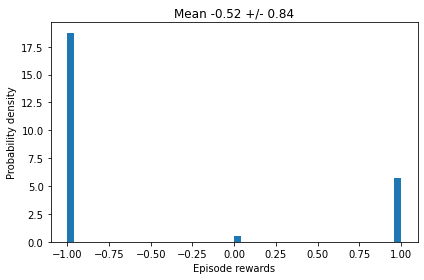

In [ ]:
runner.play(plays=100, max_steps_per_episode=max_steps_per_episode, show_plots=True)

## Save model weights for a later use (optional).

In [ ]:
episode_count = A3CAgent.global_episode
if save_model:
    model_folder = os.path.join("./models", gym_name, implementation, "Ep_" + str(episode_count).zfill(5), "model")
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    neural_nets[-1].save_weights(filepath=model_folder, save_format="tf")